This is the large casestudy for the damage dataset. Data that we are reading is 64Gb and device that I have is 32 GB so technically I cannot play around with this data

In [6]:
from dask.distributed import Client, progress
import tables
import numpy as np


In [7]:
import dask.array as da

In [8]:
path="/home/berkay/Projects/pymks/data/ms_copy_data.hdf5"


In [9]:
tps_hdf5_file = tables.open_file(path, mode='r')


In [10]:
ms_data=tps_hdf5_file.root.ms_data

In [ ]:
ms_data
# Actually it has a chunk shape (from pytables) as well  maybe it could be an issue too

In [ ]:
# import dask.dataframe as dd


In [ ]:
# dask_data=dd.read_hdf(path,'/*',mode="r")

In [ ]:
dask_array=da.from_array(ms_data,chunks=(500,257651))

In [ ]:
dask_array=dask_array[0:1000,0:51**3]

In [ ]:
dask_array

# Data Construction
Creating the Large Dask Array From HDF file:<br/>
Target Data is n* 51* 51*51<br/>
So I will first read as NP array then will construct the dask array. Basically , we are stitching them together.

In [ ]:
datasave=np.array(ms_data[1:4000,0:51**3])


In [ ]:
import dask.dataframe as dd

In [ ]:
df1=da.from_array(datasave)

In [ ]:
df1.to_hdf("datafty.hdf5",'/data')

In [ ]:
type(df1)

In [ ]:
# I guess I dont need to do that
chunksize=13000
dask_arrays = []
for i in range(10):
    import dask.array as da
    import numpy as np
    import tables
    path="/home/berkay/Projects/pymks/data/ms_copy_data.hdf5"
    tps_hdf5_file = tables.open_file(path, mode='r')
    ms_data=tps_hdf5_file.root.ms_data
#     ms_chunk=np.array(ms_data[i*chunksize:(i+1)*chunksize])
#     ms_chunk=ms_chunk[:,0:51**3]
#     ms_chunk=ms_chunk.reshape((chunksize,51,51,51))
    ms_chunk=da.from_array(np.array(ms_data[i*chunksize:(i+1)*chunksize,0:51**3]).reshape(chunksize,51,51,51),chunks=(chunksize,51,51,51))
    print("%d Chunks completed"%(i+1))
    dask_arrays.append(ms_chunk)
    %reset

In [ ]:
# ms_data.shape[0]//chunksize
x = da.concatenate(dask_arrays, axis=0)  # concatenate arrays along first axis

In [ ]:
x

In [ ]:
type(x)

Save the small chunk of the data with pytables

In [18]:
h5file = tables.open_file("new_sample.h5", "w", driver="H5FD_CORE")
a = h5file.create_array(h5file.root, "array",ms_data[0:1000,0:51**3])
h5file.close()

In [17]:
h5file.close()


# Start from Here
Unpack the data with pytables

In [1]:
import dask.array as da
import numpy as np

In [2]:
import tables
import dask.array as da

h5file = tables.open_file("new_sample.h5", "r", driver="H5FD_CORE",driver_core_backing_store=0)

In [3]:
data=h5file.root.array

In [4]:
data=da.from_array(np.array(data).reshape(1000,51,51,51),chunks=(100,51,51,51))


In [5]:
data

dask.array<array, shape=(1000, 51, 51, 51), dtype=float32, chunksize=(100, 51, 51, 51), chunktype=numpy.ndarray>

In [6]:
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation,FlattenTransformer
from dask_ml.decomposition import PCA
from sklearn.pipeline import Pipeline

In [7]:
# bl = Pipeline(steps=[
#     ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
#     ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
#     ('flatten', FlattenTransformer()),  
#     ('reducer',PCA(n_components=3))])

# # There is an issue 

In [8]:
from dask.distributed import Client, progress


In [9]:
client = Client(n_workers=1, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:41557 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.59 GB


In [29]:
c

Client Scheduler: tcp://127.0.0.1:43379 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.59 GB


In [10]:
bl1 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

# There is an issue 

In [11]:
bl2 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
      
    ])

# There is an issue 

In [12]:
import time
tic=time

In [13]:
tic = time.time()
a=bl1.fit(data)
toc = time.time()
print(tic-toc)

-15.323804140090942


In [14]:
%timeit bl1.fit(data)

15.1 s ± 65.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
a

Pipeline(memory=None,
         steps=[('discritize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0,
                                      n_state=2)),
                ('Correlations',
                 TwoPointCorrelation(correlations=[(1, 1)], cutoff=15,
                                     periodic_boundary=True)),
                ('flatten', FlattenTransformer()),
                ('reducer',
                 PCA(copy=True, iterated_power=0, n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [37]:
b=bl1.transform(data).visualize()

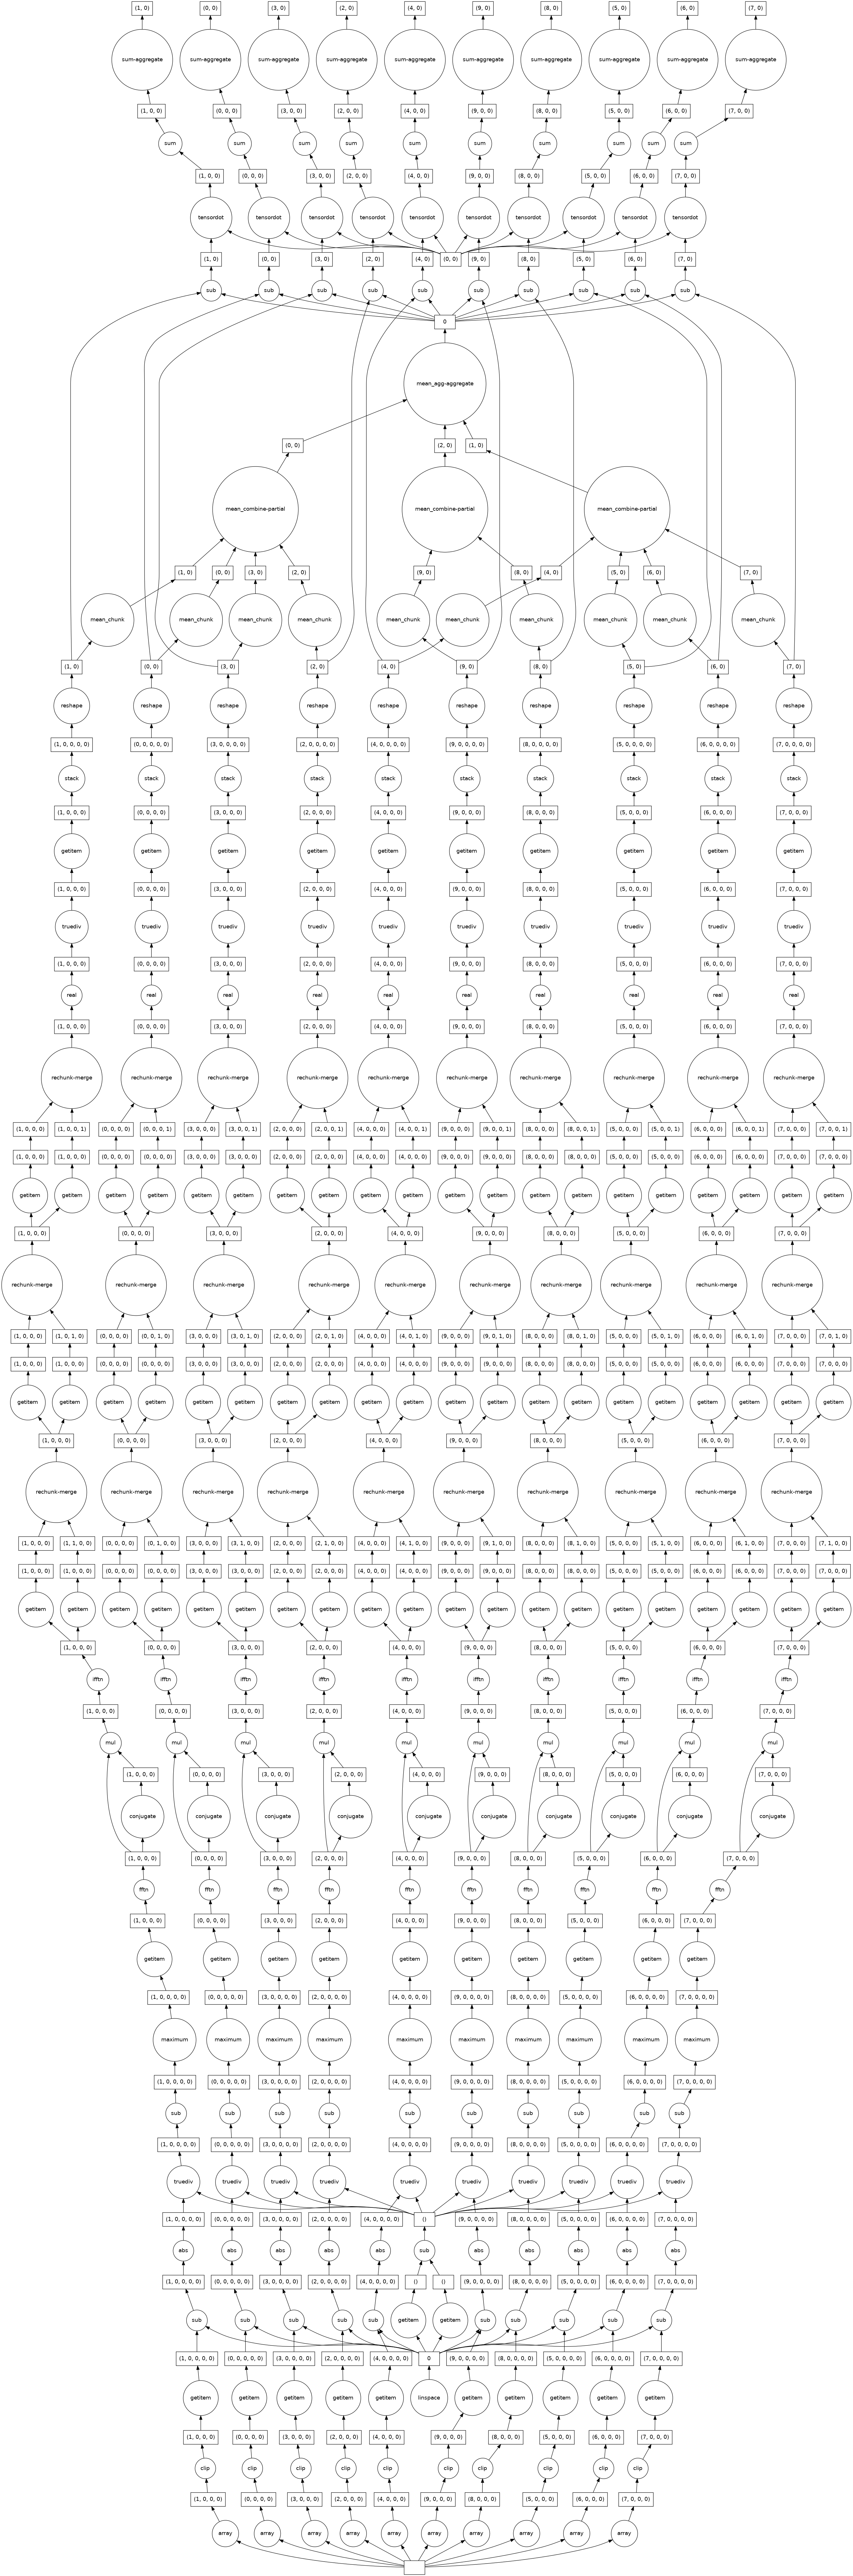

In [38]:
b

In [39]:
c=bl1.transform(data)

In [40]:
c

dask.array<sum-aggregate, shape=(1000, 3), dtype=float64, chunksize=(100, 3), chunktype=numpy.ndarray>

In [41]:
bl1.transform(data)[0]

dask.array<getitem, shape=(3,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>

In [47]:
%timeit bl1.transform(data).compute()

6.79 s ± 94.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This does not give a memory issue but for big data it crashes

In [ ]:
for i in range(10):
    print (i)
    %reset

In [ ]:
dt=da.random.random((10000,10000),chunks=(100,10000))

In [ ]:
dt

In [ ]:
a=PCA().fit(dt)

In [ ]:
a.transform(dt)

In [49]:
>>> import sys
>>> sys.getsizeof(X)


4912

In [50]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3